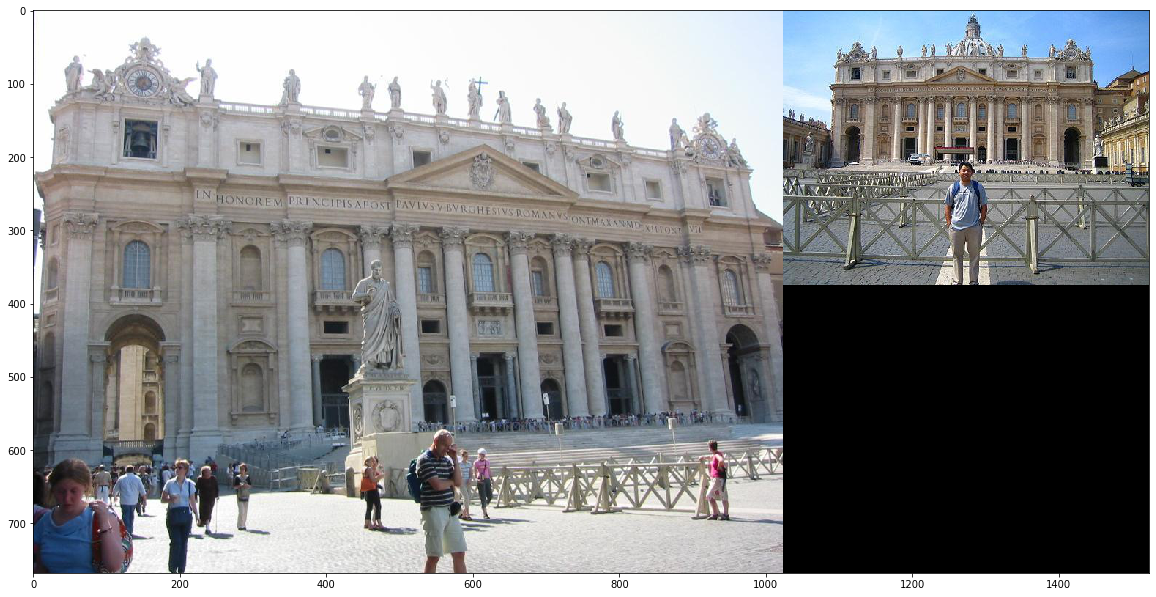

In [32]:
import numpy as np
from skimage.io import imread
from network.wrapper import GIFTDescriptor
from train.evaluation import EvaluationWrapper, Matcher
from utils.superpoint_utils import SuperPointWrapper, SuperPointDescriptor
from utils.base_utils import draw_correspondence, draw_keypoints
from utils.match_utils import compute_angle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

st_peters_idxs=[12,26,30,42,98]
pair_id=4 # you can try 0-4

M=np.loadtxt(f'demo/st_peters_{st_peters_idxs[pair_id]}.txt')
K0, K1, R = M[:3,:], M[3:6,:], M[6:,:]
img0=imread(f'demo/st_peters_{st_peters_idxs[pair_id]}_left.jpg')
img1=imread(f'demo/st_peters_{st_peters_idxs[pair_id]}_right.jpg')

def show_img(img0,img1):
    h0,h1=img0.shape[0],img1.shape[0]
    if h0<h1: img0=cv2.copyMakeBorder(img0,0,h1-h0,0,0,borderType=cv2.BORDER_CONSTANT,value=0)
    if h1<h0: img1=cv2.copyMakeBorder(img1,0,h0-h1,0,0,borderType=cv2.BORDER_CONSTANT,value=0)
    img=np.concatenate([img0,img1],axis=1)
    plt.figure(figsize=(20,16))
    plt.imshow(img)
    plt.show()

show_img(img0,img1)

In [26]:
# Load detector and descriptor

detector=SuperPointWrapper(EvaluationWrapper.load_cfg('configs/eval/superpoint_det.yaml'))
gift_desc=GIFTDescriptor(EvaluationWrapper.load_cfg('configs/eval/gift_pretrain_desc.yaml'))
superpoint_desc=SuperPointDescriptor(EvaluationWrapper.load_cfg('configs/eval/superpoint_desc.yaml'))
matcher=Matcher(EvaluationWrapper.load_cfg('configs/eval/match_v0.yaml'))

load data/model/GIFT-stage2 step 20001


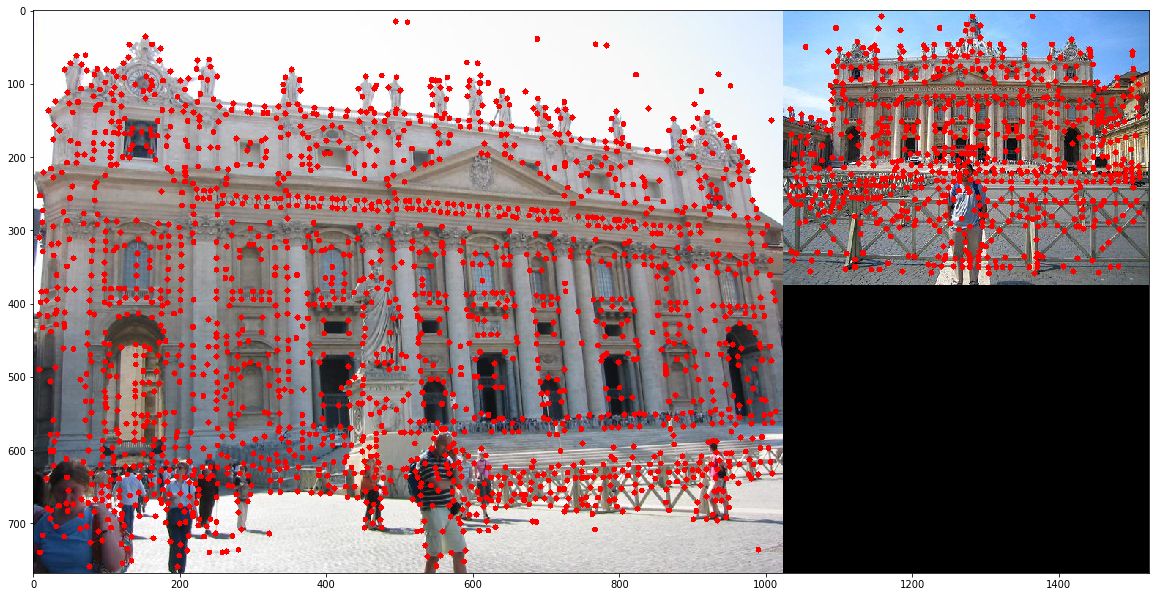

In [33]:
# Detection

kps0,_=detector(img0)
kps1,_=detector(img1)
kps_img0=draw_keypoints(img0, kps0, radius=4)
kps_img1=draw_keypoints(img1, kps1, radius=4)

h0,h1=kps_img0.shape[0],kps_img1.shape[0]
if h0<h1: kps_img0=cv2.copyMakeBorder(kps_img0,0,h1-h0,0,0,borderType=cv2.BORDER_CONSTANT,value=0)
if h1<h0: kps_img1=cv2.copyMakeBorder(kps_img1,0,h0-h1,0,0,borderType=cv2.BORDER_CONSTANT,value=0)
kps_img=np.concatenate([kps_img0,kps_img1],axis=1)
plt.figure(figsize=(20,16))
plt.imshow(kps_img)
plt.show()

In [34]:
# relative rotation estimation SuperPoint Desc

sup_desc0=superpoint_desc(img0,kps0)
sup_desc1=superpoint_desc(img1,kps1)
sup_matches=matcher.match(sup_desc0,sup_desc1)
sup_inlier_mask, sup_R, _ =EvaluationWrapper.estimate_relative_pose_from_correspondence(kps0[sup_matches[:,0]],kps1[sup_matches[:,1]],K0,K1)
sup_diff_angle=compute_angle(sup_R.T @ R)
print(f'superpoint: the angle between ground truth rotation and the estimated rotation is {sup_diff_angle:.2f} degree')

superpoint: the angle between ground truth rotation and the estimated rotation is 26.58 degree


In [35]:
# relative rotation estimation SuperPoint Desc

gift_desc0=gift_desc(img0,kps0)
gift_desc1=gift_desc(img1,kps1)
gift_matches=matcher.match(gift_desc0,gift_desc1)
gift_inlier_mask, gift_R, _ =EvaluationWrapper.estimate_relative_pose_from_correspondence(kps0[gift_matches[:,0]],kps1[gift_matches[:,1]],K0,K1)
gift_diff_angle=compute_angle(gift_R.T @ R)
print(f'GIFT: the angle between ground truth rotation and the estimated rotation is {gift_diff_angle:.2f} degree')

GIFT: the angle between ground truth rotation and the estimated rotation is 1.59 degree


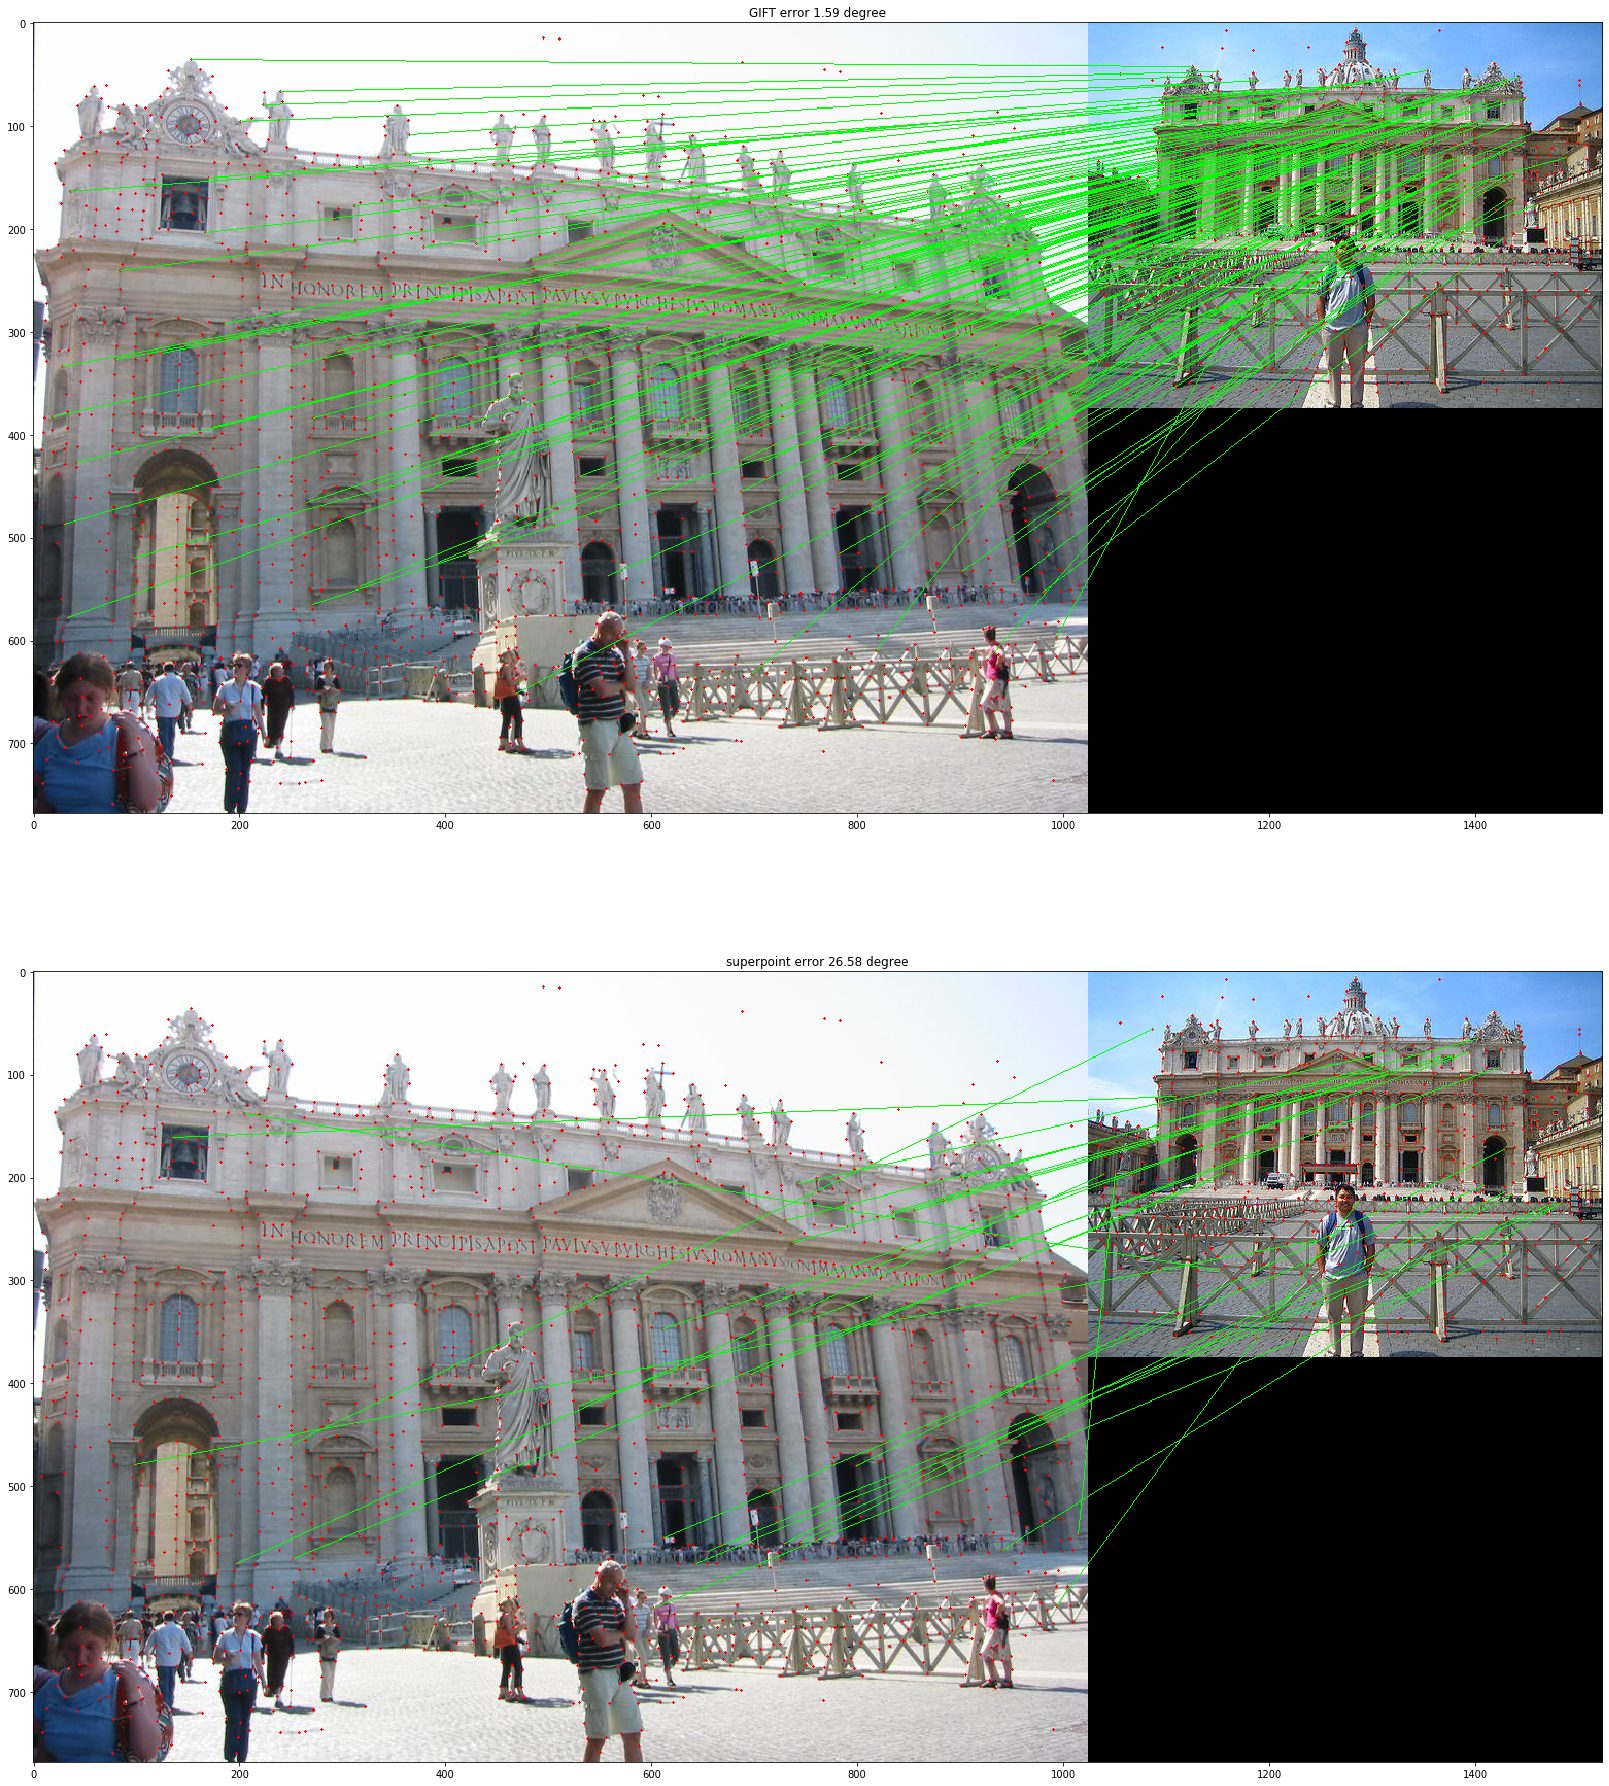

In [36]:
# draw inlier correspondences
gift_img=draw_correspondence(img0,img1,kps0,kps1,gift_matches[gift_inlier_mask])
sup_img=draw_correspondence(img0,img1,kps0,kps1,sup_matches[sup_inlier_mask])

plt.figure(figsize=(40,32))
plt.subplot(211); plt.imshow(gift_img); plt.title(f'GIFT error {gift_diff_angle:.2f} degree')
plt.subplot(212); plt.imshow(sup_img); plt.title(f'superpoint error {sup_diff_angle:.2f} degree')
plt.show()